In [1]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import spacy
import emoji

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import os 
import joblib

In [2]:
df = pd.read_csv("data.csv")

In [3]:
df.head()

,review,model,sentiment
0,The movie was a complete snoozefest. I regret...,Gemini-1.5-Flash,negative
1,"Seriously, the worst venue I've ever been to. ...",Gemini-1.5-Flash,negative
2,"This event was so poorly organized, it was a j...",Gemini-1.5-Flash,negative
3,What a disaster of a movie! The acting was aw...,Gemini-1.5-Flash,negative
4,I wouldn't recommend this venue to my worst en...,Gemini-1.5-Flash,negative


In [4]:
print(f"Shape of the dataset: {df.shape}")

Shape of the dataset: (8236, 3)


In [5]:
print(f"Columns of the dataset: {df.columns.values}")

Columns of the dataset: ['review' 'model' 'sentiment']


In [6]:
print("Data Type of columns: ")
df.dtypes

Data Type of columns: 


review       object
model        object
sentiment    object
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8236 entries, 0 to 8235
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     8236 non-null   object
 1   model      8234 non-null   object
 2   sentiment  8234 non-null   object
dtypes: object(3)
memory usage: 193.2+ KB


In [8]:
df.describe()

,review,model,sentiment
count,8236,8234,8234
unique,5678,6,3
top,This ad was pretty standard. The product was s...,Gemini-2.0-Flash-Lite,positive
freq,60,2853,3110


#### Data Preprocessing

In [10]:
# Creating a copy of the original dataset. 
df_copy = df.copy()

In [11]:
df_copy.dtypes

review       object
model        object
sentiment    object
dtype: object

The 'review' column can be changed to string datatype.

In [13]:
# Changing 'review' column to string datatype.
df_copy['review'] = df_copy['review'].astype('string')

In [14]:
df_copy.dtypes

review       string[python]
model                object
sentiment            object
dtype: object

In [15]:
# Checking null values
df_copy.isnull().sum()

review       0
model        2
sentiment    2
dtype: int64

In [16]:
df_copy = df_copy.dropna()

In [17]:
df_copy.isnull().sum()

review       0
model        0
sentiment    0
dtype: int64

In [18]:
# Checking duplicates
df_copy.duplicated().value_counts()/len(df_copy) * 100

False    68.970124
True     31.029876
Name: count, dtype: float64

Dropping duplicates results in 31% loss of data so it's better to keep them.

#### Exploratory Data Analysis

In [21]:
df_copy.columns.values

array(['review', 'model', 'sentiment'], dtype=object)

In [22]:
# Exploring 'model' 

df_copy['model'].value_counts()

model
Gemini-2.0-Flash-Lite    2853
GPT-5-mini               1661
GPT-4o-Mini              1507
Gemini-1.5-Flash         1194
Llama-3-8b-T              756
Mixtral-8x7b              263
Name: count, dtype: int64

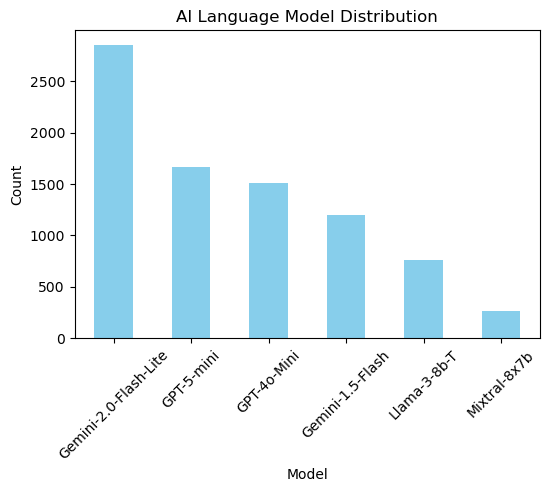

In [23]:
df_copy['model'].value_counts().plot(kind = 'bar', figsize = (6,4), color = 'skyblue')
plt.title("AI Language Model Distribution")
plt.xlabel("Model")
plt.ylabel("Count")
plt.xticks(rotation = 45)
plt.show()

In [24]:
# Exploring 'sentiment'

df_copy['sentiment'].value_counts()

sentiment
positive    3110
negative    2663
neutral     2461
Name: count, dtype: int64

In [25]:
df_copy['sentiment'].value_counts()/len(df_copy) * 100

sentiment
positive    37.770221
negative    32.341511
neutral     29.888268
Name: count, dtype: float64

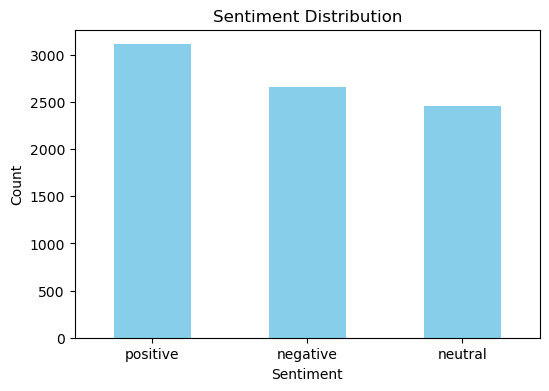

In [26]:
df_copy['sentiment'].value_counts().plot(kind = 'bar', figsize = (6,4), color = 'skyblue')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation = 360)
plt.show()

The sentiment distribution is well-balanced, so it doesn't require any kind of under or over sampling. 

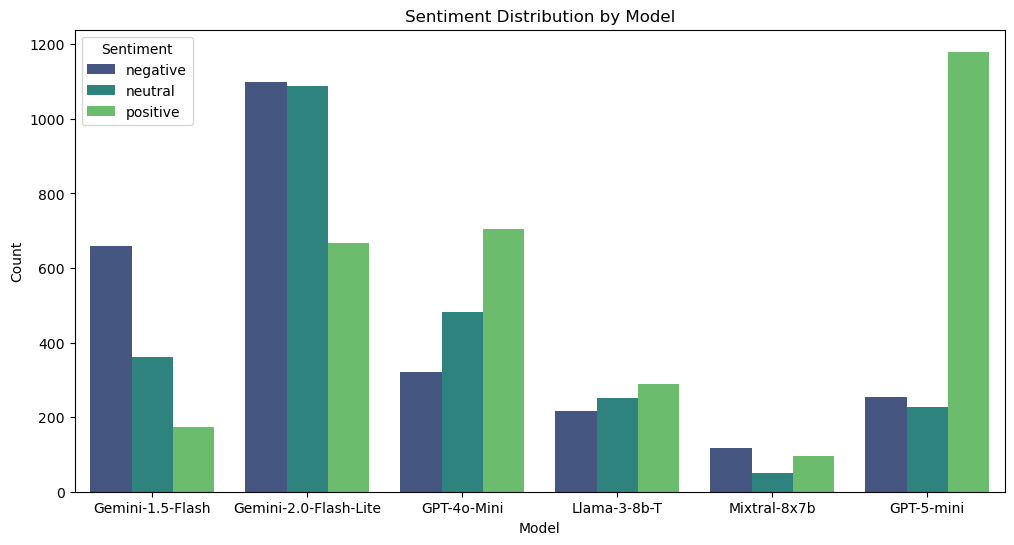

In [28]:
plt.figure(figsize = (12, 6))
sns.countplot(data = df_copy, x = 'model', hue = 'sentiment', palette = 'viridis')
plt.title("Sentiment Distribution by Model")
plt.xlabel("Model")
plt.ylabel("Count")
plt.legend(title = 'Sentiment')
plt.show()

Among all the AI language models, Gemini-2.0-Flash-Lite gave an overall well-balanced sentiment distribution of positives and negatives. GPT-5-mini gave the most positive reviews and very less negative and neutral reviews. The least reviews were given by Mixtral-8x7b.

#### Text Preprocessing

In [31]:
# Converting text to reviews

# Tokenization, stopword removal and lemmatization on review text

# Loading spaCy large English model 
nlp = spacy.load("en_core_web_lg")

# Function to tokenize, remove stopwords/punctuations and lemmatize text
def preprocess(text):
    
    # Remove emoticons
    text = emoji.replace_emoji(text, replace='') 

    # spaCy tokenization and cleaning
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct: # Removes stopwords and punctuations
            continue
        else:
            filtered_tokens.append(token.lemma_)
    return ' '.join(filtered_tokens)

In [32]:
df_copy['preprocessed_text'] = df_copy['review'].apply(lambda x: preprocess(x))

In [33]:
df_copy.head()

,review,model,sentiment,preprocessed_text
0,The movie was a complete snoozefest. I regret...,Gemini-1.5-Flash,negative,movie complete snoozefest regret second to...
1,"Seriously, the worst venue I've ever been to. ...",Gemini-1.5-Flash,negative,seriously bad venue sound terrible seat unco...
2,"This event was so poorly organized, it was a j...",Gemini-1.5-Flash,negative,event poorly organize joke leave early feeli...
3,What a disaster of a movie! The acting was aw...,Gemini-1.5-Flash,negative,disaster movie acting awful plot nonsensical...
4,I wouldn't recommend this venue to my worst en...,Gemini-1.5-Flash,negative,recommend venue bad enemy dirty cramped over...


In [34]:
# A few examples of preprocessed reviews

print(f"Before:", df_copy['review'][0])
print(f"After:", df_copy['preprocessed_text'][0])
print("\n")
print(f"Before:", df_copy['review'][45])
print(f"After:", df_copy['preprocessed_text'][45])
print("\n")
print(f"Before:", df_copy['review'][130])
print(f"After:", df_copy['preprocessed_text'][130])

Before: The movie was a complete snoozefest.  I regretted every second.  Total waste of money.
After: movie complete snoozefest   regret second   total waste money


Before: The movie was slow, boring, and had terrible acting.
After: movie slow boring terrible acting


Before: This event was underwhelming and disappointing.  I expected so much more.
After: event underwhelming disappointing   expect


In [35]:
# Changing sentiment i.e. positive = 1, negative = -1, and neutral = 0
df_copy['sentiment_label'] = df_copy['sentiment'].map({
    'positive': 1,
    'negative': -1,
    'neutral': 0
})

In [36]:
df_copy.head()

,review,model,sentiment,preprocessed_text,sentiment_label
0,The movie was a complete snoozefest. I regret...,Gemini-1.5-Flash,negative,movie complete snoozefest regret second to...,-1
1,"Seriously, the worst venue I've ever been to. ...",Gemini-1.5-Flash,negative,seriously bad venue sound terrible seat unco...,-1
2,"This event was so poorly organized, it was a j...",Gemini-1.5-Flash,negative,event poorly organize joke leave early feeli...,-1
3,What a disaster of a movie! The acting was aw...,Gemini-1.5-Flash,negative,disaster movie acting awful plot nonsensical...,-1
4,I wouldn't recommend this venue to my worst en...,Gemini-1.5-Flash,negative,recommend venue bad enemy dirty cramped over...,-1


In [37]:
df_copy['sentiment_label'].value_counts()

sentiment_label
 1    3110
-1    2663
 0    2461
Name: count, dtype: int64

#### Machine Learning

In [39]:
# train-test-split

X_train, X_test, y_train, y_test = train_test_split(
    df_copy.preprocessed_text,
    df_copy.sentiment_label,
    test_size = 0.20,
    random_state = 2002,
    stratify = df_copy.sentiment_label
)

In [40]:
print(f" Shape of X_train: {X_train.shape}")

print(f" Shape of X_test: {X_test.shape}")

print(f" Shape of y_train: {y_train.shape}")

print(f" Shape of y_test: {y_test.shape}")

 Shape of X_train: (6587,)
 Shape of X_test: (1647,)
 Shape of y_train: (6587,)
 Shape of y_test: (1647,)


In [41]:
X_train.head()

4975    ABC kettle boil water fast perfect tea instant...
4337     DEF Portable Speaker amazing great sound quality
8048    vitamin c serum oxidize fast like open affect ...
6329    brand customer service terrible respond inquir...
7382    air fryer crisps frozen fry quickly basket wip...
Name: preprocessed_text, dtype: object

In [42]:
X_test.head()

6265    get amazing new experience gift partner photog...
6726    insulated lunch bag keep food cold day fit loo...
676                                  angry   unacceptable
4813                     ABC air freshener chemical smell
1085    store disorganized difficult navigate   find look
Name: preprocessed_text, dtype: object

In [43]:
y_train.head()

4975    1
4337    1
8048   -1
6329   -1
7382    1
Name: sentiment_label, dtype: int64

In [44]:
y_test.head()

6265    1
6726    1
676    -1
4813   -1
1085   -1
Name: sentiment_label, dtype: int64

#### Logistic Regression

In [46]:
pipe = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=3,
        max_df=0.9,
        max_features=60000,
        sublinear_tf=True,
        strip_accents="unicode"
    )),
    ("clf", LogisticRegression(
        max_iter=300,
        class_weight="balanced",   # helps with imbalance
        n_jobs=-1,
        solver="saga"
    ))
])

param_dist = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__max_features": [30000, 60000, 90000],
    "clf__C": [0.2, 0.5, 1.0, 2.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=12,
    scoring="f1_macro",        # care about all classes
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
best_pipe = search.best_estimator_

# 4) Evaluate on held-out test set
y_pred = best_pipe.predict(X_test)
print("Test accuracy:", round(accuracy_score(y_test, y_pred), 4))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'tfidf__ngram_range': (1, 1), 'tfidf__max_features': 30000, 'clf__C': 2.0}
Test accuracy: 0.918
              precision    recall  f1-score   support

          -1       0.96      0.91      0.93       533
           0       0.89      0.88      0.89       492
           1       0.91      0.96      0.93       622

    accuracy                           0.92      1647
   macro avg       0.92      0.91      0.92      1647
weighted avg       0.92      0.92      0.92      1647



#### Multinomial Naive Bayes

In [48]:
pipe_nb = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=3,
        max_df=0.9,
        max_features=60000,
        sublinear_tf=True,
        strip_accents="unicode"
    )),
    ("clf", MultinomialNB())
])

param_dist_nb = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__max_features": [30000, 60000, 90000],
    "tfidf__use_idf": [True, False],
    "tfidf__norm": ["l2", "l1"],
    "clf__alpha": [0.1, 0.3, 0.7, 1.0, 2.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search_nb = RandomizedSearchCV(
    estimator=pipe_nb,
    param_distributions=param_dist_nb,
    n_iter=12,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search_nb.fit(X_train, y_train)

print("NB Best params:", search_nb.best_params_)
best_nb = search_nb.best_estimator_

y_pred_nb = best_nb.predict(X_test)
print("NB Test accuracy:", round(accuracy_score(y_test, y_pred_nb), 4))
print(classification_report(y_test, y_pred_nb))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
NB Best params: {'tfidf__use_idf': True, 'tfidf__norm': 'l2', 'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 90000, 'clf__alpha': 0.3}
NB Test accuracy: 0.8871
              precision    recall  f1-score   support

          -1       0.97      0.84      0.90       533
           0       0.88      0.84      0.86       492
           1       0.83      0.97      0.90       622

    accuracy                           0.89      1647
   macro avg       0.90      0.88      0.89      1647
weighted avg       0.89      0.89      0.89      1647



#### Decision Tree Classifier

In [50]:
pipe_dt = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=3,
        max_df=0.9,
        max_features=60000,
        sublinear_tf=True,
        strip_accents="unicode"
    )),
    ("chi2", SelectKBest(score_func=chi2, k=30000)),  # reduce dimensionality for trees
    ("clf", DecisionTreeClassifier(random_state=42, class_weight="balanced"))
])

param_dist_dt = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__max_features": [30000, 60000, 90000],
    "chi2__k": [10000, 20000, 30000],
    "clf__criterion": ["gini", "entropy"],
    "clf__max_depth": [None, 20, 50, 100],
    "clf__min_samples_split": [2, 5, 10, 20],
    "clf__min_samples_leaf": [1, 2, 5, 10],
    "clf__max_features": [None, "sqrt", "log2"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search_dt = RandomizedSearchCV(
    estimator=pipe_dt,
    param_distributions=param_dist_dt,
    n_iter=20,                 # a few more iters helps trees
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search_dt.fit(X_train, y_train)

print("DT Best params:", search_dt.best_params_)
best_dt = search_dt.best_estimator_

y_pred_dt = best_dt.predict(X_test)
print("DT Test accuracy:", round(accuracy_score(y_test, y_pred_dt), 4))
print(classification_report(y_test, y_pred_dt))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\Azhar\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=20000 is greater than n_features=5235. All the features will be returned.
  warnings.warn(


DT Best params: {'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 60000, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_features': None, 'clf__max_depth': 100, 'clf__criterion': 'gini', 'chi2__k': 20000}
DT Test accuracy: 0.8537
              precision    recall  f1-score   support

          -1       0.91      0.83      0.87       533
           0       0.86      0.81      0.83       492
           1       0.81      0.91      0.86       622

    accuracy                           0.85      1647
   macro avg       0.86      0.85      0.85      1647
weighted avg       0.86      0.85      0.85      1647



Logistic Regression has performed the best so that model is chosen.

In [52]:
# Save one file for your server
joblib.dump(best_pipe, "sentiment_pipeline.joblib")
print("Saved: sentiment_pipeline.joblib")

Saved: sentiment_pipeline.joblib
